In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from IPython.display import Image  

/kaggle/input/online-p2p-lending/Master_Loan_Summary.csv
/kaggle/input/images/images/3.PNG
/kaggle/input/images/images/2.jpg
/kaggle/input/images/images/1.PNG
/kaggle/input/images/images/4.PNG


# Credit Risk Analysis Case Study

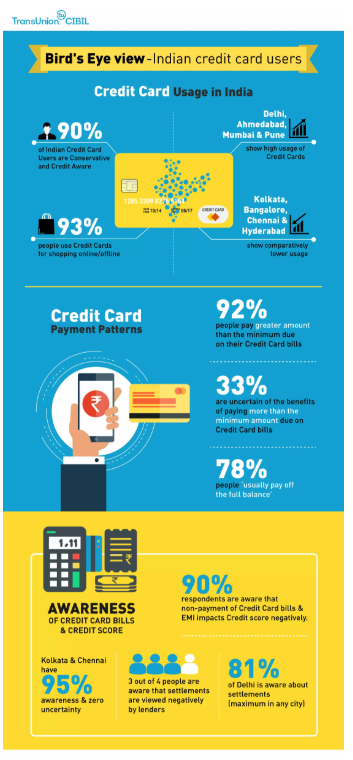

In [2]:
Image("/kaggle/input/images/images/4.PNG")

## As per the reports by Transunion Cibil 78% of people pay off their balance and less that 2% of people fail to pay back their loans.

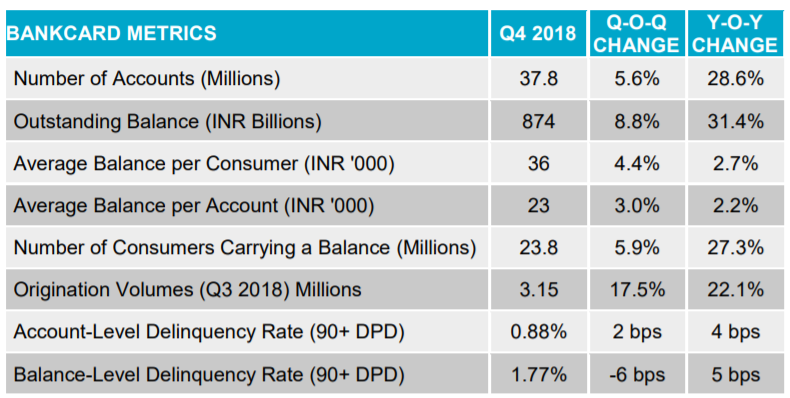

In [3]:
Image("/kaggle/input/images/images/2.jpg")

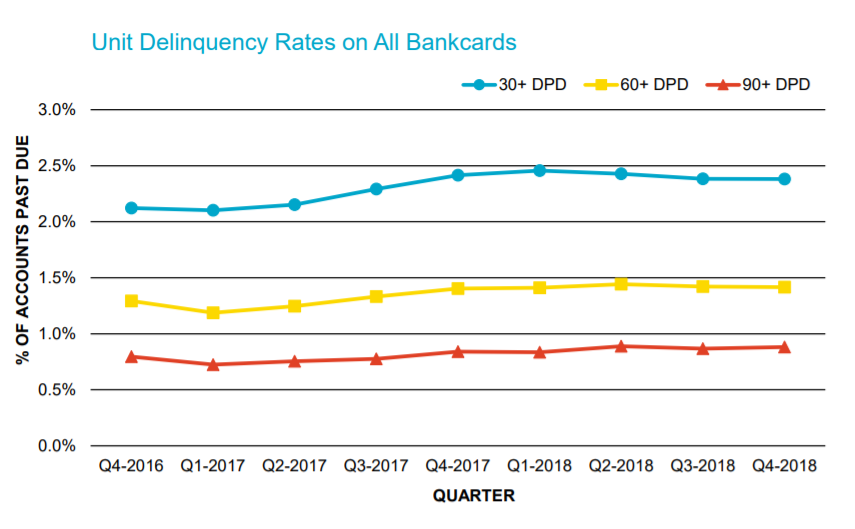

In [4]:
Image("/kaggle/input/images/images/3.PNG")

# However since the provided data is for 37.8 million customers with average balance Rs 36,000 we will take into consideration other data sets to introduce variation in our calculations.

## This data is of a peer to peer lending company showing historical loans from both Prosper and Lending Club from 2013 to 2018.
### Link to dataset: https://www.kaggle.com/skihikingkevin/online-p2p-lending

In [5]:
# Import the libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Read the data.
dataP2P = pd.read_csv('/kaggle/input/online-p2p-lending/Master_Loan_Summary.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# HELPER FUNCTIONS
def change_dtype(dtype , df , col_names):
    """ 
    Set dtype of columns given to the dtype given.
    Input: dtype= Desired Datatype
           df = DataFrame
           col_names = Names of columns we want to change the datatype of.   
    """
    for col in col_names:
        df[col] = df[col].astype(dtype)
def find_late_payment_statistics(df,col_name):
    """
    Find the percentage of people who made late payments based on due date categorisation.
    Input: df = DataFrame for analysis.
           col_name = The columns which contains days past due date.  
    Output: A dictionary containing the percentage of people who paid on time, late by 30,45 and 60 days.
    """
    temp_dict = {'Paid on time':0,'30 days late':0 , '45 days late':0 , '60 days late':0}
    total = len(df)
    temp_dict['Paid on time'] = round((len(df[(df[col_name]==0)])/total) * 100 , 2)
    temp_dict['30 days late'] = round((len(df[(df[col_name]>0) & (df[col_name]<=30)])/total) * 100,2)
    temp_dict['45 days late'] = round((len(df[(df[col_name]>30) & (df[col_name]<=45)])/total) * 100,2)
    temp_dict['60 days late'] = round((len(df[(df[col_name]>45) & (df[col_name]<=60)])/total) * 100 , 2)
    return temp_dict        
        

In [8]:
# Change the columns to appropriate datatype and extract month and rows.
change_dtype('datetime64' , dataP2P , ['origination_date','last_payment_date','next_payment_due_date'])
dataP2P['Year'] = dataP2P['origination_date'].apply(lambda x: x.year)
dataP2P['Month'] = dataP2P['origination_date'].apply(lambda x: x.month)

# For our observations we will take customers with similar account balance i.e less than 2000.
dataP2P = dataP2P[(dataP2P['amount_borrowed']<2000) & (dataP2P['days_past_due']<=60)]

Text(0.5, 1.0, 'Percentage of late payments as per days past due.')

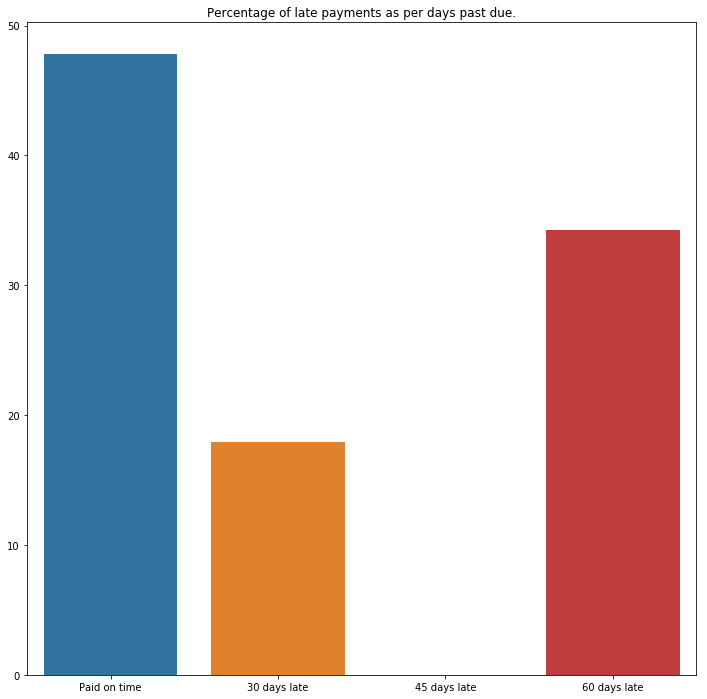

In [9]:
# Find late payment statistics.
P2P_stat = find_late_payment_statistics(dataP2P, 'days_past_due')

# Plotting the values
plt.figure(figsize=(12,12))
sns.barplot(x = list(P2P_stat.keys()) , y = list(P2P_stat.values()))
plt.title('Percentage of late payments as per days past due.')

In [10]:
# Actual Percentage
P2P_stat

{'Paid on time': 47.85,
 '30 days late': 17.9,
 '45 days late': 0.0,
 '60 days late': 34.26}

### As per the data-set the late values in 45 days is 0. This might be due to the discrepancy in dataset.

## So we determine the type of customers of each type as:
### Customers who paid on time = (78 + 47.85)/2 = 62.75% = 62%
### Customers who were 60 days late = (34.26 + 2)/2  = 19%
### Out of these people we will assume that 3 % of the people who were past the due date(60 days) couldn't make the payment i.e defaults were 3%.
### Out of the remaining 19% I divide the ratio as :
### 60% of the people made payment after 30 days = 60% of 19 = 11.4% = 11%
### The remaining people made the payment after 45 days = 19-11 = 8%

# Final Solution

# Information provided.
## Facts:
### 1. Average card balance is Rs 1000
### 2. Each card has an interest rate of 15%
### 3. Membership fee is Rs 20 per card
### 4.Loss rate is 3%
### 5. Rs 25 operating cost per card
### 6. Rs 10 affiliation fee per card (cost to the group organization itself, so that their members get this awesome card program)
### 7. 6.5% cost of funds (that credit card company must pay to the bank where it gets money)
### 8. Bill/statement is issued on 1st of every month
### 9. Credit-free period = 15 days from the bill/statement issue date.

In [11]:
# Define columns for data-frame and percentage of type of customers.
col = ['Date_Issued', 'Due_Date',  'Date_Paid', 'Balance_Days','Customer_Type','No_of_Customers','Rate','Principal' , 'Interest_Per_Person','Total_Interest' , 'Total_Principal']
percentage_of_customers = {'>15':.62 , '30':.11 , '45':.08 , '60':.16}

# I assume that 3% of people never pay back their loan.

## Assumptions:
### 1. I assume that the customers frequently take loans i.e they take the next loan immediately after they pay the last one.
### 2. The customers use their entire balance when they take loan and every month they pay minimum of 5% of the balance.
### 3. The monthly rate of interest is 15%.
### 4. First Loan was issued on 17th December 2018.

# Scenario 1:
## i) The interest rate is simple interest.
## ii) Interest is calculated on a daily basis.
## iii) The average card balance is the average end of month balance.
## iv) All members are more than a year old.

### Helper Functions.

In [12]:
def calculate_interest_on_revolving_balance(date_issued , due_date , date_paid , amount , rate , si = True, period = 4, balance_date = "01", decrement_rate = 5):
    """
    Function to calculate interest on revolving balance.
    Input:
    date_issued: Date the loan was issued.
    due_date: Due date for the loan.
    date_paid: Date the loan was paid.
    amount: Principal amount.
    rate: Yearly rate of interest.
    si: Boolean column to determine if Simple interest or compound interest will be calculated.
    period : compounding period
    balance_date : balance date in string.
    decrement_rate: The percentage of loan the customer pays back every month in percentage.
    Output: Total interest due.
    
    """
    # Initialize values
    total_days = 0
    days = 0
    counter = 0
    interest = 0
    decrement_rate = decrement_rate/100
    rate = rate/12
    
    # Convert the dates to pd.DateTime.
    date_issued = pd.to_datetime(date_issued)
    date_paid = pd.to_datetime(date_paid)
    due_date = pd.to_datetime(due_date)
    
    # If paid on time no interest is generated
    if date_paid == due_date:
        return 0,0
    
    # Generate next_balance date
    month = date_issued.month
    year = date_issued.year
    current_balance_date = get_next_balance_date(month,year , balance_date=balance_date)
    
    # Set next balance date as current balance date.
    next_balance_date = current_balance_date
    while(date_paid>next_balance_date):
        if counter == 0:
            # If due date falls after the current balance date, we need to subtract the current balance date from due date.
            if (due_date>current_balance_date):
                # It means I have no outstanding balance in current month.
                days = 0
                interest = 0
            else:
                days = (current_balance_date - due_date).days
                total_days += days
                amount = amount * (1-decrement_rate)
                
                # Calculate interest
                if si == True:
                    interest = calculate_si_for_one(amount , days, rate)
                else:
                    interest = calculate_compound_interest(rate ,amount , days/365 , period=period )
                    
                # Set current balance date as next balance date and find next balance date.   
                current_month = current_balance_date.month
                current_year = current_balance_date.year    
                current_balance_date = next_balance_date
                next_balance_date = get_next_balance_date(current_month , current_year , balance_date = balance_date)
                counter += 1
        else:
            # Find days due.
            days = (next_balance_date - current_balance_date).days
            
            # Total days due
            total_days += days
            
            # Calculate interest.
            if si == True:
                interest += calculate_si_for_one(amount , days, rate)
            else:
                interest += calculate_compound_interest(rate ,amount , days/365 , period=period )
                        
                
            # Set current balance date as next balance date and update next balance date. 
            amount = amount * (1-decrement_rate)
            current_balance_date = next_balance_date
            current_month = current_balance_date.month
            current_year = current_balance_date.year
            next_balance_date = get_next_balance_date(current_month , current_year , balance_date = balance_date)
            

    # Check for remaining due days in current_balance_date
    if (date_paid> current_balance_date):
        # Find days due for the last month.
        days = (date_paid-current_balance_date ).days
        # Total days due
        total_days += days

        # Amount due.
        amount = amount * (1-decrement_rate)

        # Calculate interest.
        if si == True:
            interest += calculate_si_for_one(amount , days, rate)
        else:
            interest += calculate_compound_interest(rate ,amount , days/365 , period=period )
            
    return interest , total_days

def generate_ledger_si(start_date,late_days, creditfree_days = 15, rate = 15 , type_of_customer = ">15", percentage_of_customers = percentage_of_customers, amount = 1000 , total_customers=1000 ):
    
    """
    This function will create a ledger with the kind of customer given and calculate the interest charged based on the days
    past due date.
    Input:
    start_date: The date when the first loan was issued.
    late_days: The number of days a person makes payment past the due date.
    creditfree_days: 15 as provided in the question.
    rate: Yearly rate of interest.
    type_of_customer: Type of customer.
    percentage_of_customers: Dictionary containing the percentage of customers of each kind.
    amount: Principal Balance.
    Totat_Customers: Total Number of Customers.
    Output:
    Dataframe containing the ledger of a particular kind of customer.
    
    """
    counter = 0
    
    # Initialize the parameters needed to find the interest
    temp_dict = dict.fromkeys(col)
    start_date = pd.to_datetime(start_date)
    due_date = start_date + np.timedelta64(creditfree_days , 'D')
    date_paid =  due_date + np.timedelta64(late_days, 'D')
    start_date , due_date , date_paid
    interest_for_one , balance_days = calculate_interest_on_revolving_balance(start_date , due_date , date_paid , amount, rate) 
    no_of_customers = find_number_of_customers(type_of_customer , percentage_of_customers , total_customers  )
    total_principal = no_of_customers * amount 
    
    # Plug values into first row
    temp_dict['Date_Issued'] = start_date
    temp_dict['Due_Date'] = due_date
    temp_dict['Date_Paid'] = date_paid
    temp_dict['Customer_Type'] = type_of_customer
    temp_dict['Rate'] = rate
    temp_dict['Principal'] = amount
    temp_dict['Balance_Days'] = balance_days
    temp_dict['No_of_Customers'] = no_of_customers
    temp_dict['Interest_Per_Person'] = interest_for_one
    temp_dict['Total_Interest'] = calculate_interest_for_all(no_of_customers , interest_for_one)
    temp_dict['Total_Principal'] = total_principal
    # Populate the df
    initialized_df = pd.DataFrame([temp_dict])
    
    # Set previous date
    current_date_issued = start_date
    current_due_date = due_date
    current_date_paid = date_paid
    while(counter == 0):
            # Create a temp_row to append it.
            temp_row = dict.fromkeys(col)
            next_date_issued = current_date_paid + np.timedelta64(1,'D')
            next_due_date = next_date_issued+ np.timedelta64(creditfree_days,'D')
            next_date_paid = next_due_date+ np.timedelta64(late_days,'D')
            balance_days = calc_balance_days(next_date_issued , next_due_date , next_date_paid)
            no_of_customers = find_number_of_customers(type_of_customer , percentage_of_customers , total_customers)
            interest_for_one = calculate_si_for_one(amount ,balance_days, rate)
            total_principal = no_of_customers * amount 
            
            # Append the row
            temp_row['Date_Issued'] = next_date_issued
            temp_row['Due_Date'] = next_due_date
            temp_row['Date_Paid'] = next_date_paid
            temp_row['Customer_Type'] = type_of_customer
            temp_row['Rate'] = rate
            temp_row['Principal'] = amount
            temp_row['Balance_Days'] = balance_days
            temp_row['No_of_Customers'] = no_of_customers
            temp_row['Interest_Per_Person'] = interest_for_one
            temp_row['Total_Interest'] = calculate_interest_for_all(no_of_customers , interest_for_one)
            temp_row['Total_Principal'] = no_of_customers * amount
            
            # Set the current rows as next rows
            current_date_issued = next_date_issued
            current_due_date = next_due_date
            current_date_paid = next_date_paid
            
            #Append the df
            initialized_df = initialized_df.append([temp_row], ignore_index = True)
            
            #Condition to break while loop
            if next_due_date.year == 2020:
                counter += 1
    return initialized_df
    
    
def str2date(month):
    """
    It will convert a date given in string to proper format so that it can be used in Pandas Timestamp function.
    Eg: "1" will return "01".
    Input:
    month: The date in string.
    Output: The month in proper format.
    """
    if len(month)==1:
        month = "0" + month
    return month  

def get_next_balance_date(month , year, balance_date="01"):
    """
    It will generate the next balance date which will be used in calculating the days past due.
    Input:
    month: Current month of loan issued(Integer).
    year: Current year of loan issued(Integer).
    balance_date: The date at which the balance amount is generated(String).
    Output: 
    The next balance date in Timestamp format.
    
    """
    if month<12:
        return pd.to_datetime(str(year) + "-" + str2date(str(month+1))+ "-" + balance_date)
    else:
        return pd.to_datetime(str(year+1) + "-" + str2date(str(1))+ "-" + balance_date)
    
def calc_balance_days(date_issued,due_date , date_paid , balance_date = "01"):
    """
    This function will calculate the number of days a person is due based date_issued and date_paid.
    Input: 
    date_issued: Date the loan was issued.
    date_paid: Date the loan was paid back.
    Output:
    The number of days past due in integer.
    """
    
    # Convert the values to pandas.DateTime
    date_issued = pd.Timestamp(date_issued)
    date_paid = pd.Timestamp(date_paid)
    due_date = pd.Timestamp(due_date)
    
    # Set the balance days = 0.
    balance_days = 0
    
    # Check if bill was paid on time.
    if due_date == date_paid:
        return balance_days
    
    # First check if due date is after the balance date.
    # If I take credit on 1/01/19 I will get the balance 01/02/19
    counter = 0
    issued_month = date_issued.month
    issued_year = date_issued.year
    prev_balance_date = next_balance_date =get_next_balance_date(issued_month , issued_year)
   
    while(date_paid>next_balance_date):
        if counter == 0:
            balance_days = (next_balance_date - due_date).days
            counter +=1
        else:
            balance_days += (next_balance_date - prev_balance_date).days
        # Increment the month:
        prev_balance_date = next_balance_date
        next_balance_date = get_next_balance_date(next_balance_date.month , next_balance_date.year)
        
    # Final step
    balance_days += (date_paid - prev_balance_date).days
    return balance_days

# Calculate Simple Interest-day-wise
def calculate_si_for_one(principal , balance_days , rate):
    """
    Function which calculates Simple Interest based on yearly interest.
    Input:
    Principal: Principal amount.
    balance_days: Number of days past due.
    rate: Yearly rate of interest.
    Output:
    Simple interest
    """
    si = principal * balance_days * (rate/100) * (1/365)
    return si

def calculate_interest_for_all(number_of_customers , interest_for_one):
    """
    Calculates interest for all the customers based on the number of customers.
    """
    return number_of_customers * interest_for_one

def find_number_of_customers(type_of_customer , dict_customer_percentage , total_customers):
    """
    Find the number of customers of a given type.
    """
    return dict_customer_percentage[type_of_customer] * total_customers

In [13]:
# Create the ledger for different customers.
percentage_of_customers = {'>15':.62 , '30':.11 , '45':.08 , '60':.16}
customer_15 = generate_ledger_si("2017-12-17", late_days=0 , rate=180, percentage_of_customers= percentage_of_customers)
customer_30 = generate_ledger_si("2017-12-17", late_days=30 ,type_of_customer='30' , rate=180, percentage_of_customers= percentage_of_customers)
customer_45 = generate_ledger_si("2017-12-17", late_days=45, type_of_customer='45', rate=180, percentage_of_customers= percentage_of_customers)
customer_60 = generate_ledger_si("2017-12-17", late_days=60, type_of_customer='60', rate=180, percentage_of_customers= percentage_of_customers)

# # As we don't issue another loan to customers who paid 60 days after due date we remove them.
customer_60 = pd.DataFrame(customer_60[:1])

# Concatenate them to a dataframe.
si_df = pd.concat([customer_15, customer_30 , customer_45, customer_60] , ignore_index=True)

In [14]:
# Display the dataframe.
si_df

,Date_Issued,Due_Date,Date_Paid,Balance_Days,Customer_Type,No_of_Customers,Rate,Principal,Interest_Per_Person,Total_Interest,Total_Principal
0,2017-12-17,2018-01-01,2018-01-01,0,>15,620.0,180,1000,0.000000,0.000000,620000.0
1,2018-01-02,2018-01-17,2018-01-17,0,>15,620.0,180,1000,0.000000,0.000000,620000.0
2,2018-01-18,2018-02-02,2018-02-02,0,>15,620.0,180,1000,0.000000,0.000000,620000.0
3,2018-02-03,2018-02-18,2018-02-18,0,>15,620.0,180,1000,0.000000,0.000000,620000.0
4,2018-02-19,2018-03-06,2018-03-06,0,>15,620.0,180,1000,0.000000,0.000000,620000.0
...,...,...,...,...,...,...,...,...,...,...,...
73,2019-06-19,2019-07-04,2019-08-18,45,45,80.0,180,1000,221.917808,17753.424658,80000.0
74,2019-08-19,2019-09-03,2019-10-18,45,45,80.0,180,1000,221.917808,17753.424658,80000.0
75,2019-10-19,2019-11-03,2019-12-18,45,45,80.0,180,1000,221.917808,17753.424658,80000.0
76,2019-12-19,2020-01-03,2020-02-17,45,45,80.0,180,1000,221.917808,17753.424658,80000.0


## Q1: How much profit % is generated in 1 year?

In [15]:
principal_invested = si_df['Total_Principal'].sum()
interest_earned = si_df['Total_Interest'].sum()

# Calculate the money lost due to .03% of the customers who never paid back.
money_lost = .03 * 1000 * 1000

# Calculate the amount went in generating cards for every customer.
cost_of_cards = 25 * 1000

# The money paid to the credit company by the organization for issuing the card.
money_per_card = 10 * 1000

# Money paid to the bank by the credit card company for the principal.
money_paid_to_bank = .065 * 1000 * 1000

# Calculate total principal.
total_principal = money_lost + principal_invested + cost_of_cards + money_paid_to_bank

# Calculate total returns.
returns = principal_invested + money_per_card + interest_earned

# Calculate the profit/loss %.
diff = returns - total_principal
calc_percentage = diff/total_principal * 100

if calc_percentage<0:
    print('The credit card company could not break even.')
    print('It incurred a loss of ' , round(calc_percentage,2) , '%.')
    print('Loss suffered is ', diff)
else:
    print('The credit card company made a profit.')
    print('It made a profit of  ' , round(calc_percentage,2) , '%.')
    print('Profit made is ', diff)

The credit card company made a profit.
It made a profit of   1.14 %.
Profit made is  369663.02643835545


## Q2: The 3% loss rate can either mean either 3% of the outstanding balance defaults or 3% of the borrowers default on their entire balance. If the average balance is increased to $2000, what happens to the loss?

In [16]:
# Create the ledger for different customers.
percentage_of_customers = {'>15':.62 , '30':.11 , '45':.08 , '60':.16}
customer_15 = generate_ledger_si("2017-12-17", late_days=0 , amount = 2000  , rate=180)
customer_30 = generate_ledger_si("2017-12-17", late_days=30 ,type_of_customer='30' , amount = 2000, rate=180)
customer_45 = generate_ledger_si("2017-12-17", late_days=45, type_of_customer='45' ,  amount = 2000, rate=180)
customer_60 = generate_ledger_si("2017-12-17", late_days=60, type_of_customer='60',  amount = 2000, rate=180)

# # As we don't issue another loan to customers who paid 60 days after due date we remove them.
customer_60 = pd.DataFrame(customer_60[:1])

# Concatenate them to a dataframe.
si_df = pd.concat([customer_15, customer_30 , customer_45, customer_60] , ignore_index=True)

In [17]:
# Display the dataframe.
si_df

,Date_Issued,Due_Date,Date_Paid,Balance_Days,Customer_Type,No_of_Customers,Rate,Principal,Interest_Per_Person,Total_Interest,Total_Principal
0,2017-12-17,2018-01-01,2018-01-01,0,>15,620.0,180,2000,0.000000,0.000000,1240000.0
1,2018-01-02,2018-01-17,2018-01-17,0,>15,620.0,180,2000,0.000000,0.000000,1240000.0
2,2018-01-18,2018-02-02,2018-02-02,0,>15,620.0,180,2000,0.000000,0.000000,1240000.0
3,2018-02-03,2018-02-18,2018-02-18,0,>15,620.0,180,2000,0.000000,0.000000,1240000.0
4,2018-02-19,2018-03-06,2018-03-06,0,>15,620.0,180,2000,0.000000,0.000000,1240000.0
...,...,...,...,...,...,...,...,...,...,...,...
73,2019-06-19,2019-07-04,2019-08-18,45,45,80.0,180,2000,443.835616,35506.849315,160000.0
74,2019-08-19,2019-09-03,2019-10-18,45,45,80.0,180,2000,443.835616,35506.849315,160000.0
75,2019-10-19,2019-11-03,2019-12-18,45,45,80.0,180,2000,443.835616,35506.849315,160000.0
76,2019-12-19,2020-01-03,2020-02-17,45,45,80.0,180,2000,443.835616,35506.849315,160000.0


In [18]:
principal_invested = si_df['Total_Principal'].sum()
interest_earned = si_df['Total_Interest'].sum()

# Calculate the money lost due to .03% of the customers who never paid back.
money_lost = .03 * 1000 * 2000

# Calculate the amount went in generating cards for every customer.
cost_of_cards = 25 * 1000

# The money paid to the credit company by the organization for issuing the card.
money_per_card = 10 * 1000

# Money paid to the bank by the credit card company for the principal.
money_paid_to_bank = .065 * 1000 * 2000

# Calculate total principal.
total_principal = money_lost + principal_invested + cost_of_cards + money_paid_to_bank

# Calculate total returns.
returns = principal_invested + money_per_card + interest_earned

# Calculate the profit/loss %.
diff = returns - total_principal
calc_percentage = diff/total_principal * 100

if calc_percentage<0:
    print('The credit card company could not break even.')
    print('It incurred a loss of ' , round(calc_percentage,2) , '%.')
    print('Loss suffered is ', diff)
else:
    print('The credit card company made a profit.')
    print('It made a profit of  ' , round(calc_percentage,2) , '%.')
    print('Profit made is ', diff)

The credit card company made a profit.
It made a profit of   1.17 %.
Profit made is  754326.0528767109


### If the balance is increased to Rs.2000 the credit card company slightly increases its profit percentage.

## Q3: Is a borrower with a low balance more or less likely to default then a borrower with a high balance? Why ? explain clearly

### A borrower with a low balance might be more likely to default as if he has a low balance:
### 1. He may be a new customer or
### 2. He may have a bad credit score or
### 3. He might be having low income i.e he might not be in a stable job , a student etc.
### So there is a chance that the borrower with a low balance might default.


## Q4: The group company has now become unhappy with the credit card provider. it wants to start its own credit card. But for that, it will need to purchase the customers from the current credit card company. If the affilated group offered Rs 20 per account to purchase all the customers from the credit card company, what would there profit be? (assume that we are only talking about 1 year)

In [19]:
# Create the ledger for different customers.
percentage_of_customers = {'>15':.62 , '30':.11 , '45':.08 , '60':.16}
customer_15 = generate_ledger_si("2017-12-17", late_days=0 , rate=180, percentage_of_customers= percentage_of_customers)
customer_30 = generate_ledger_si("2017-12-17", late_days=30 ,type_of_customer='30' , rate=180, percentage_of_customers= percentage_of_customers)
customer_45 = generate_ledger_si("2017-12-17", late_days=45, type_of_customer='45', rate=180, percentage_of_customers= percentage_of_customers)
customer_60 = generate_ledger_si("2017-12-17", late_days=60, type_of_customer='60', rate=180, percentage_of_customers= percentage_of_customers)

# # As we don't issue another loan to customers who paid 60 days after due date we remove them.
customer_60 = pd.DataFrame(customer_60[:1])

# Concatenate them to a dataframe.
si_df = pd.concat([customer_15, customer_30 , customer_45, customer_60] , ignore_index=True)

In [20]:
principal_invested = si_df['Total_Principal'].sum()
interest_earned = si_df['Total_Interest'].sum()

# Calculate the money lost due to .03% of the customers who never paid back.
money_lost = .03 * 1000 * 1000

# Calculate the amount went in operating cost of cards for every customer.
cost_of_cards = 50 * 1000

# The money paid to the credit company by the organization for buying the customers.
money_per_card = 20 * 1000

# Money paid to the bank by the organization is zero as it can issue loans from its own funds.
money_paid_to_bank = 0

# Calculate total principal.
total_principal = money_lost + principal_invested + cost_of_cards + money_paid_to_bank

# Calculate total returns.
returns = principal_invested + money_per_card + interest_earned

# Calculate the profit/loss %.
diff = returns - total_principal
calc_percentage = diff/total_principal * 100

if calc_percentage<0:
    print('The company could not break even.')
    print('It incurred a loss of ' , round(calc_percentage,2) , '%.')
    print('Loss suffered is ', diff)
else:
    print('The company made a profit.')
    print('It made a profit of  ' , round(calc_percentage,2) , '%.')
    print('Profit made is Rs ', diff)

The company made a profit.
It made a profit of   1.3 %.
Profit made is Rs  419663.02643835545


### The organization will make a profit as it can adjust fund from its own resources, so it won't have to pay 6.5% interest to the bank. So , even if the operating cost might increase from 25 to upto Rs 450 it will be making a profit.

## Q5: What numbers can the financial institution change to convince the affiliated group not to want to purchase, while still not going into a loss? Give a range of what the new numbers are (min and max)?

### Answer: Credit Lending Company can show that a higher % of people defaults say 10 % or greater and 90% of people pay the due on time. 

In [21]:
percentage_of_customers = {'>15':.90 , '30':.00 , '45':.00 , '60':.05}
# Create the ledger for different customers.
customer_15 = generate_ledger_si("2017-12-17", late_days=0 , rate=180 , percentage_of_customers= percentage_of_customers)
customer_30 = generate_ledger_si("2017-12-17", late_days=30 ,type_of_customer='30' , rate=180 , percentage_of_customers= percentage_of_customers)
customer_45 = generate_ledger_si("2017-12-17", late_days=45, type_of_customer='45', rate=180, percentage_of_customers= percentage_of_customers)
customer_60 = generate_ledger_si("2017-12-17", late_days=60, type_of_customer='60', rate=180, percentage_of_customers= percentage_of_customers)

# # As we don't issue another loan to customers who paid 60 days after due date we remove them.
customer_60 = pd.DataFrame(customer_60[:1])

# Concatenate them to a dataframe.
si_df = pd.concat([customer_15, customer_30 , customer_45, customer_60] , ignore_index=True)

principal_invested = si_df['Total_Principal'].sum()
interest_earned = si_df['Total_Interest'].sum()

# Calculate the money lost due to .03% of the customers who never paid back.
money_lost = .10 * 1000 * 1000

# Calculate the amount went in operating cost of cards for every customer.
cost_of_cards = 25 * 1000

# The money paid to the credit company by the organization for buying the customers.
money_per_card = 20 * 1000

# Money paid to the bank by the organization is zero as it can issue loans from its own funds.
money_paid_to_bank = 0

# Calculate total principal.
total_principal = money_lost + principal_invested + cost_of_cards + money_paid_to_bank

# Calculate total returns.
returns = principal_invested + money_per_card + interest_earned

# Calculate the profit/loss %.
diff = returns - total_principal
calc_percentage = diff/total_principal * 100

if calc_percentage<0:
    print('The company could not break even.')
    print('It incurred a loss of ' , round(calc_percentage,2) , '%.')
    print('Loss suffered is ', diff)
else:
    print('The company made a profit.')
    print('It made a profit of  ' , round(calc_percentage,2) , '%.')
    print('Profit made is Rs ', diff)

The company could not break even.
It incurred a loss of  -0.24 %.
Loss suffered is  -103858.8800085634


## The credit lending company can convince the orginaztions that its employees would expect loans at subsidized rate of interest. They might convince the organization that the company would not be able to charge an interest rate greater than 10% anually.

In [22]:
# Create the ledger for different customers.
percentage_of_customers = {'>15':.62 , '30':.11 , '45':.08 , '60':.16}
customer_15 = generate_ledger_si("2017-12-17", late_days=0 , rate=10, percentage_of_customers= percentage_of_customers)
customer_30 = generate_ledger_si("2017-12-17", late_days=30 ,type_of_customer='30' , rate=10, percentage_of_customers= percentage_of_customers)
customer_45 = generate_ledger_si("2017-12-17", late_days=45, type_of_customer='45', rate=10, percentage_of_customers= percentage_of_customers)
customer_60 = generate_ledger_si("2017-12-17", late_days=60, type_of_customer='60', rate=10, percentage_of_customers= percentage_of_customers)

# # As we don't issue another loan to customers who paid 60 days after due date we remove them.
customer_60 = pd.DataFrame(customer_60[:1])

# Concatenate them to a dataframe.
si_df = pd.concat([customer_15, customer_30 , customer_45, customer_60] , ignore_index=True)

principal_invested = si_df['Total_Principal'].sum()
interest_earned = si_df['Total_Interest'].sum()

# Calculate the money lost due to .03% of the customers who never paid back.
money_lost = .03 * 1000 * 1000

# Calculate the amount went in operating cost of cards for every customer.
cost_of_cards = 25 * 1000

# The money paid to the credit company by the organization for buying the customers.
money_per_card = 20 * 1000

# Money paid to the bank by the organization is zero as it can issue loans from its own funds.
money_paid_to_bank = 0

# Calculate total principal.
total_principal = money_lost + principal_invested + cost_of_cards + money_paid_to_bank

# Calculate total returns.
returns = principal_invested + money_per_card + interest_earned

# Calculate the profit/loss %.
diff = returns - total_principal
calc_percentage = diff/total_principal * 100

if calc_percentage<0:
    print('The company could not break even.')
    print('It incurred a loss of ' , round(calc_percentage,2) , '%.')
    print('Loss suffered is ', diff)
else:
    print('The company made a profit.')
    print('It made a profit of  ' , round(calc_percentage,2) , '%.')
    print('Profit made is Rs ', diff)

The company could not break even.
It incurred a loss of  -0.03 %.
Loss suffered is  -8352.054086759686


## The card company might also try to convice the organization that operating cost per card will be greater since the credit card company operates in bulk it was able to afford a lower rate. So, even if the organization charges at an yearly rate of 15% and cost per card of Rs 50 they will suffer a loss.

In [23]:
# Create the ledger for different customers.
percentage_of_customers = {'>15':.62 , '30':.11 , '45':.08 , '60':.16}
customer_15 = generate_ledger_si("2017-12-17", late_days=0 , rate=15, percentage_of_customers= percentage_of_customers)
customer_30 = generate_ledger_si("2017-12-17", late_days=30 ,type_of_customer='30' , rate=15, percentage_of_customers= percentage_of_customers)
customer_45 = generate_ledger_si("2017-12-17", late_days=45, type_of_customer='45', rate=15, percentage_of_customers= percentage_of_customers)
customer_60 = generate_ledger_si("2017-12-17", late_days=60, type_of_customer='60', rate=15, percentage_of_customers= percentage_of_customers)

# # As we don't issue another loan to customers who paid 60 days after due date we remove them.
customer_60 = pd.DataFrame(customer_60[:1])

# Concatenate them to a dataframe.
si_df = pd.concat([customer_15, customer_30 , customer_45, customer_60] , ignore_index=True)

principal_invested = si_df['Total_Principal'].sum()
interest_earned = si_df['Total_Interest'].sum()

# Calculate the money lost due to .03% of the customers who never paid back.
money_lost = .03 * 1000 * 1000

# Calculate the amount went in operating cost of cards for every customer.
cost_of_cards = 50 * 1000

# The money paid to the credit company by the organization for buying the customers.
money_per_card = 20 * 1000

# Money paid to the bank by the organization is zero as it can issue loans from its own funds.
money_paid_to_bank = 0

# Calculate total principal.
total_principal = money_lost + principal_invested + cost_of_cards + money_paid_to_bank

# Calculate total returns.
returns = principal_invested + money_per_card + interest_earned

# Calculate the profit/loss %.
diff = returns - total_principal
calc_percentage = diff/total_principal * 100

if calc_percentage<0:
    print('The company could not break even.')
    print('It incurred a loss of ' , round(calc_percentage,2) , '%.')
    print('Loss suffered is ', diff)
else:
    print('The company made a profit.')
    print('It made a profit of  ' , round(calc_percentage,2) , '%.')
    print('Profit made is Rs ', diff)

The company could not break even.
It incurred a loss of  -0.06 %.
Loss suffered is  -20028.081130135804


## Q6: What is the extra cost(if any) company will have to incur if the customer delays the payment of the credit card bill after the due date?

### Extra Cost  incurred by the company is the 6.5% of the funds the credit card company has to pay to the bank.

## Q7: Is it beneficial for the company if the customer pays the credit card bill after the due date? (express your views as a business strategy analyst with a short example)?

### Unless , a person defaults the company will make a profit as delay is directly proportional to interest generated. 

# Scenario 2:
## i) The interest rate is compounded quarterly.
## ii) Interest is calculated on a monthly basis.
## iii) Membership grows at 5% month on month.
## iv) Card balance grows at 5% per month for each member.
## v) The average card balance is the average end of month balance.

In [24]:
def calculate_monthly_amount(amount , increment_rate = 5):
    
    """
    This function returns the monthly amount based on month on month increment rate.
    Input:
    amount: amount to increment.
    increment_rate: month on month growth rate.
    Output:
    Dictionary containing monthly amounts.
    """
    
    temp_dict = {1:amount , 2:0 , 3:0 , 4:0 , 5:0 , 6:0 , 7:0 , 8:0 , 9:0 , 10:0 , 11:0 , 12:0 ,13:0}
    for m in range(2,14):
        new_amount = round(amount * (1+ increment_rate/100) , 2)
        temp_dict[m] = new_amount
        amount = new_amount
        
    return temp_dict

def calculate_compound_interest(rate_yearly, amount , time_in_year , period = 4):
    
    """
    Function to calculate compound interest.
    Input:
    rate_yearly: Yearly rate of interest.
    amount: Principal.
    time_in_year: Time given in years.
    period: semi-anually , quarterly etc.
    Output:
    Returns compound interest.
    """
    a = rate_yearly/(period * 100)
    b = 1 + a
    nt = period * time_in_year
    total_amount = amount * b**nt
    total_interest = total_amount - amount 
    return total_interest

def generate_ledger_ci(start_date,late_days, creditfree_days = 15, rate = 15 , type_of_customer = ">15", percentage_of_customers = percentage_of_customers, amount = 1000 , total_customers=1000 ):
    
    """
    This function will create a ledger with the kind of customer given and calculate the compound interest charged based on the days
    past due date.
    Input:
    start_date: The date when the first loan was issued.
    late_days: The number of days a person makes payment past the due date.
    creditfree_days: 15 as provided in the question.
    rate: Yearly rate of interest.
    type_of_customer: Type of customer.
    percentage_of_customers: Dictionary containing the percentage of customers of each kind.
    amount: Principal Balance.
    Totat_Customers: Total Number of Customers.
    Output:
    Dataframe containing the ledger of a particular kind of customer.
    
    """
    # Initialize a counter
    counter = 0
    
    # Initialize the parameters needed to find the interest
    temp_dict = dict.fromkeys(col)
    start_date = pd.to_datetime(start_date)
    due_date = start_date + np.timedelta64(creditfree_days , 'D')
    date_paid =  due_date + np.timedelta64(late_days, 'D')
    no_of_customers = find_number_of_customers(type_of_customer , percentage_of_customers , total_customers  )
    month_loan_issued = start_date.month
    amount_dict = calculate_monthly_amount(amount)
    monthly_amount = amount_dict[month_loan_issued]
    interest_for_one , balance_days = calculate_interest_on_revolving_balance(start_date , due_date , date_paid , monthly_amount , 180, si = 'False' )
    total_principal = no_of_customers * monthly_amount 
    
    # Append the dictionary as dataframe.
    temp_dict['Date_Issued'] = start_date
    temp_dict['Due_Date'] = due_date
    temp_dict['Date_Paid'] = date_paid
    temp_dict['Customer_Type'] = type_of_customer
    temp_dict['Rate'] = rate
    temp_dict['Principal'] = amount
    temp_dict['Balance_Days'] = balance_days
    temp_dict['No_of_Customers'] = no_of_customers
    temp_dict['Interest_Per_Person'] = interest_for_one
    temp_dict['Total_Interest'] = calculate_interest_for_all(no_of_customers , interest_for_one)
    temp_dict['Total_Principal'] = no_of_customers * amount
    ledger_df = pd.DataFrame([temp_dict])
    
    # Initialize previous dates for creating other rows.
    prev_date_issued = start_date
    prev_due_date = due_date
    previous_date_paid = date_paid
    
    # Create the rest of df
    while(counter == 0):
        # Create a temp_row to append it and initialize the values.
            temp_row = dict.fromkeys(col)
            new_date_issued = previous_date_paid + np.timedelta64(1,'D')
            new_due_date = new_date_issued + np.timedelta64(creditfree_days , 'D')
            new_date_paid = new_due_date + np.timedelta64(late_days , 'D')
            balance_days = calc_balance_days(new_date_issued , new_due_date , new_date_paid)
            if new_due_date.year != 2020:
                month_loan_issued = new_date_issued.month
            else:
                month_loan_issued = 13 
            monthly_amount = amount_dict[month_loan_issued]
            interest_for_one = calculate_compound_interest(rate , monthly_amount , (balance_days/(30*12)))

            total_principal = no_of_customers * amount
   
        # Append the row
            temp_row['Date_Issued'] = new_date_issued
            temp_row['Due_Date'] = new_due_date
            temp_row['Date_Paid'] = new_date_paid
            temp_row['Customer_Type'] = type_of_customer
            temp_row['Rate'] = rate
            temp_row['Principal'] = monthly_amount
            temp_row['Balance_Days'] = balance_days
            temp_row['No_of_Customers'] = no_of_customers
            temp_row['Interest_Per_Person'] = interest_for_one
            temp_row['Total_Interest'] = calculate_interest_for_all(no_of_customers , interest_for_one)
            temp_row['Total_Principal'] = no_of_customers * amount
            
            # Set the current rows as latest rows
            
            prev_date_issued = new_date_issued
            prev_due_date = new_due_date
            previous_date_paid = new_date_paid
            
            #Append the df
            ledger_df = ledger_df.append([temp_row], ignore_index = True)
            
            #Condition to break while loop
            if (new_due_date.year == 2020):
                counter += 1
    return ledger_df




## Q1: How much profit % is generated in 1 year?

In [25]:
# Create the ledger for different customers.
percentage_of_customers = {'>15':.62 , '30':.11 , '45':.08 , '60':.16}
customer_15 = generate_ledger_ci("2017-12-17", late_days=0 , rate=180, percentage_of_customers= percentage_of_customers)
customer_30 = generate_ledger_ci("2017-12-17", late_days=30 ,type_of_customer='30' , rate=180, percentage_of_customers= percentage_of_customers)
customer_45 = generate_ledger_ci("2017-12-17", late_days=45, type_of_customer='45', rate=180, percentage_of_customers= percentage_of_customers)
customer_60 = generate_ledger_ci("2017-12-17", late_days=60, type_of_customer='60', rate=180, percentage_of_customers= percentage_of_customers)

# # As we don't issue another loan to customers who paid 60 days after due date we remove them.
customer_60 = pd.DataFrame(customer_60[:1])

# Concatenate them to a dataframe.
ci_df = pd.concat([customer_15, customer_30 , customer_45, customer_60] , ignore_index=True)

In [26]:
principal_invested = ci_df['Total_Principal'].sum()
interest_earned = ci_df['Total_Interest'].sum()

# Calculate the money lost due to .03% of the customers who never paid back.
money_lost = .03 * 1000 * 1000

# Calculate the amount went in operating cost of cards for every customer.
cost_of_cards = 25 * 1000

# The money paid to the credit company by the organization for buying the customers.
money_per_card = 20 * 1000

# Money paid to the bank by the organization is zero as it can issue loans from its own funds.
money_paid_to_bank = 0

# Calculate total principal.
total_principal = money_lost + principal_invested + cost_of_cards + money_paid_to_bank

# Calculate total returns.
returns = principal_invested + money_per_card + interest_earned

# Calculate the profit/loss %.
diff = returns - total_principal
calc_percentage = diff/total_principal * 100

if calc_percentage<0:
    print('The company could not break even.')
    print('It incurred a loss of ' , round(calc_percentage,2) , '%.')
    print('Loss suffered is ', diff)
else:
    print('The company made a profit.')
    print('It made a profit of  ' , round(calc_percentage,2) , '%.')
    print('Profit made is Rs ', diff)

The company made a profit.
It made a profit of   1.73 %.
Profit made is Rs  559733.1086666286


### The credit company generated a profit of 1.73% or Rs 559733 for one year. Compound interest with quarterly compounding period has generated greater profit than simple interest.

## Q2: The 3% loss rate can either mean either 3% of the outstanding balance defaults or 3% of the borrowers default on their entire balance. If the average balance is increased to $2000, what happens to the loss?

In [27]:
# Create the ledger for different customers.
percentage_of_customers = {'>15':.62 , '30':.11 , '45':.08 , '60':.16}
customer_15 = generate_ledger_ci("2017-12-17", late_days=0 , amount = 2000  , rate=180)
customer_30 = generate_ledger_ci("2017-12-17", late_days=30 ,type_of_customer='30' , amount = 2000, rate=180)
customer_45 = generate_ledger_ci("2017-12-17", late_days=45, type_of_customer='45' ,  amount = 2000, rate=180)
customer_60 = generate_ledger_ci("2017-12-17", late_days=60, type_of_customer='60',  amount = 2000, rate=180)

# # As we don't issue another loan to customers who paid 60 days after due date we remove them.
customer_60 = pd.DataFrame(customer_60[:1])

# Concatenate them to a dataframe.
ci_df = pd.concat([customer_15, customer_30 , customer_45, customer_60] , ignore_index=True)

# Display the dataframe.
ci_df

,Date_Issued,Due_Date,Date_Paid,Balance_Days,Customer_Type,No_of_Customers,Rate,Principal,Interest_Per_Person,Total_Interest,Total_Principal
0,2017-12-17,2018-01-01,2018-01-01,0,>15,620.0,180,2000.00,0.000000,0.000000,1240000.0
1,2018-01-02,2018-01-17,2018-01-17,0,>15,620.0,180,2000.00,0.000000,0.000000,1240000.0
2,2018-01-18,2018-02-02,2018-02-02,0,>15,620.0,180,2000.00,0.000000,0.000000,1240000.0
3,2018-02-03,2018-02-18,2018-02-18,0,>15,620.0,180,2100.00,0.000000,0.000000,1240000.0
4,2018-02-19,2018-03-06,2018-03-06,0,>15,620.0,180,2100.00,0.000000,0.000000,1240000.0
...,...,...,...,...,...,...,...,...,...,...,...
73,2019-06-19,2019-07-04,2019-08-18,45,45,80.0,180,2552.56,521.129266,41690.341264,160000.0
74,2019-08-19,2019-09-03,2019-10-18,45,45,80.0,180,2814.20,574.545546,45963.643709,160000.0
75,2019-10-19,2019-11-03,2019-12-18,45,45,80.0,180,3102.66,633.437384,50674.990687,160000.0
76,2019-12-19,2020-01-03,2020-02-17,45,45,80.0,180,3591.71,733.281566,58662.525317,160000.0


In [28]:
principal_invested = ci_df['Total_Principal'].sum()
interest_earned = ci_df['Total_Interest'].sum()

# Calculate the money lost due to .03% of the customers who never paid back.
money_lost = .03 * 1000 * 2000

# Calculate the amount went in generating cards for every customer.
cost_of_cards = 25 * 1000

# The money paid to the credit company by the organization for issuing the card.
money_per_card = 10 * 1000

# Money paid to the bank by the credit card company for the principal.
money_paid_to_bank = .065 * 1000 * 2000

# Calculate total principal.
total_principal = money_lost + principal_invested + cost_of_cards + money_paid_to_bank

# Calculate total returns.
returns = principal_invested + money_per_card + interest_earned

# Calculate the profit/loss %.
diff = returns - total_principal
calc_percentage = diff/total_principal * 100

if calc_percentage<0:
    print('The credit card company could not break even.')
    print('It incurred a loss of ' , round(calc_percentage,2) , '%.')
    print('Loss suffered is ', diff)
else:
    print('The credit card company made a profit.')
    print('It made a profit of  ' , round(calc_percentage,2) , '%.')
    print('Profit made is ', diff)

The credit card company made a profit.
It made a profit of   1.52 %.
Profit made is  984473.5195122585


### The credit company still made a profit but its profit percentage reduced. Here , I assumed that 3% of the total customers defaulted on their loan.

## Q3: Is a borrower with a low balance more or less likely to default then a borrower with a high balance? Why ? explain clearly

### A borrower with a low balance might be more likely to default as if he has a low balance:
### He may be a new customer or
### He may have a bad credit score or
### He might be having low income i.e he might not be in a stable job , a student etc.
### So there is a chance that the borrower with a low balance might default.


## Q4: The group company has now become unhappy with the credit card provider. it wants to start its own credit card. But for that, it will need to purchase the customers from the current credit card company. If the affilated group offered Rs 20 per account to purchase all the customers from the credit card company, what would there profit be? (assume that we are only talking about 1 year)

In [29]:
# Create the ledger for different customers.
percentage_of_customers = {'>15':.62 , '30':.11 , '45':.08 , '60':.16}
customer_15 = generate_ledger_ci("2017-12-17", late_days=0 , rate=180, percentage_of_customers= percentage_of_customers)
customer_30 = generate_ledger_ci("2017-12-17", late_days=30 ,type_of_customer='30' , rate=180, percentage_of_customers= percentage_of_customers)
customer_45 = generate_ledger_ci("2017-12-17", late_days=45, type_of_customer='45', rate=180, percentage_of_customers= percentage_of_customers)
customer_60 = generate_ledger_ci("2017-12-17", late_days=60, type_of_customer='60', rate=180, percentage_of_customers= percentage_of_customers)

# # As we don't issue another loan to customers who paid 60 days after due date we remove them.
customer_60 = pd.DataFrame(customer_60[:1])

# Concatenate them to a dataframe.
ci_df = pd.concat([customer_15, customer_30 , customer_45, customer_60] , ignore_index=True)

In [30]:
ci_df

,Date_Issued,Due_Date,Date_Paid,Balance_Days,Customer_Type,No_of_Customers,Rate,Principal,Interest_Per_Person,Total_Interest,Total_Principal
0,2017-12-17,2018-01-01,2018-01-01,0,>15,620.0,180,1000.00,0.000000,0.000000,620000.0
1,2018-01-02,2018-01-17,2018-01-17,0,>15,620.0,180,1000.00,0.000000,0.000000,620000.0
2,2018-01-18,2018-02-02,2018-02-02,0,>15,620.0,180,1000.00,0.000000,0.000000,620000.0
3,2018-02-03,2018-02-18,2018-02-18,0,>15,620.0,180,1050.00,0.000000,0.000000,620000.0
4,2018-02-19,2018-03-06,2018-03-06,0,>15,620.0,180,1050.00,0.000000,0.000000,620000.0
...,...,...,...,...,...,...,...,...,...,...,...
73,2019-06-19,2019-07-04,2019-08-18,45,45,80.0,180,1276.28,260.564633,20845.170632,80000.0
74,2019-08-19,2019-09-03,2019-10-18,45,45,80.0,180,1407.09,287.270732,22981.658527,80000.0
75,2019-10-19,2019-11-03,2019-12-18,45,45,80.0,180,1551.31,316.714609,25337.168688,80000.0
76,2019-12-19,2020-01-03,2020-02-17,45,45,80.0,180,1795.84,366.637721,29331.017667,80000.0


In [31]:
principal_invested = ci_df['Total_Principal'].sum()
interest_earned = ci_df['Total_Interest'].sum()

# Calculate the money lost due to .03% of the customers who never paid back.
money_lost = .03 * 1000 * 1000

# Calculate the amount went in operating cost of cards for every customer.
cost_of_cards = 55 * 1000

# The money paid to the credit company by the organization for buying the customers.
money_per_card = 20 * 1000

# Money paid to the bank by the organization is zero as it can issue loans from its own funds.
money_paid_to_bank = 0

# Calculate total principal.
total_principal = money_lost + principal_invested + cost_of_cards + money_paid_to_bank

# Calculate total returns.
returns = principal_invested + money_per_card + interest_earned

# Calculate the profit/loss %.
diff = returns - total_principal
calc_percentage = diff/total_principal * 100

if calc_percentage<0:
    print('The company could not break even.')
    print('It incurred a loss of ' , round(calc_percentage,2) , '%.')
    print('Loss suffered is ', diff)
else:
    print('The company made a profit.')
    print('It made a profit of  ' , round(calc_percentage,2) , '%.')
    print('Profit made is Rs ', diff)

The company made a profit.
It made a profit of   1.64 %.
Profit made is Rs  529733.1086666286


### The organization will get better profits by replacing the card company. As it can use its own resources for giving loans to it customers rather than paying interest to a bank. The operating cost per card might increase(assuming it to be Rs 55 per card) because the credit lending company was operating in bulk so they had cheaper operating cost per card.

## Q5: What numbers can the financial institution change to convince the affiliated group not to want to purchase, while still not going into a loss? Give a range of what the new numbers are (min and max)?
### Answer: Credit Lending Company can show that a higher % of people defaults say 10 % or greater and 90% of people pay the due on time. 

In [32]:
percentage_of_customers = {'>15':.90, '30':.00 , '45':.00 , '60':.05}
# Create the ledger for different customers.
customer_15 = generate_ledger_ci("2017-12-17", late_days=0 , rate=180 , percentage_of_customers= percentage_of_customers)
customer_30 = generate_ledger_ci("2017-12-17", late_days=30 ,type_of_customer='30' , rate=180 , percentage_of_customers= percentage_of_customers)
customer_45 = generate_ledger_ci("2017-12-17", late_days=45, type_of_customer='45', rate=180, percentage_of_customers= percentage_of_customers)
customer_60 = generate_ledger_ci("2017-12-17", late_days=60, type_of_customer='60', rate=180, percentage_of_customers= percentage_of_customers)

# # As we don't issue another loan to customers who paid 60 days after due date we remove them.
customer_60 = pd.DataFrame(customer_60[:1])

# Concatenate them to a dataframe.
ci_df = pd.concat([customer_15, customer_30 , customer_45, customer_60] , ignore_index=True)

principal_invested = ci_df['Total_Principal'].sum()
interest_earned = ci_df['Total_Interest'].sum()

# Calculate the money lost due to .03% of the customers who never paid back.
money_lost = .10 * 1000 * 1000

# Calculate the amount went in operating cost of cards for every customer.
cost_of_cards = 25 * 1000

# The money paid to the credit company by the organization for buying the customers.
money_per_card = 20 * 1000

# Money paid to the bank by the organization is zero as it can issue loans from its own funds.
money_paid_to_bank = 0

# Calculate total principal.
total_principal = money_lost + principal_invested + cost_of_cards + money_paid_to_bank

# Calculate total returns.
returns = principal_invested + money_per_card + interest_earned

# Calculate the profit/loss %.
diff = returns - total_principal
calc_percentage = diff/total_principal * 100

if calc_percentage<0:
    print('The company could not break even.')
    print('It incurred a loss of ' , round(calc_percentage,2) , '%.')
    print('Loss suffered is ', diff)
else:
    print('The company made a profit.')
    print('It made a profit of  ' , round(calc_percentage,2) , '%.')
    print('Profit made is Rs ', diff)



The company could not break even.
It incurred a loss of  -0.24 %.
Loss suffered is  -103072.69504678994


## The credit lending company can convince the orginaztions that its employees would expect loans at subcidized rate of interest. They might convince the organization that the company would not be able to charge an interest rate greater than 10% anually. Even if 10% of there employees default they will run into a loss.

In [33]:
# Create the ledger for different customers.
percentage_of_customers = {'>15':.60 , '30':.11 , '45':.10 , '60':.08}
customer_15 = generate_ledger_ci("2017-12-17", late_days=0 , rate=10, percentage_of_customers= percentage_of_customers)
customer_30 = generate_ledger_ci("2017-12-17", late_days=30 ,type_of_customer='30' , rate=10, percentage_of_customers= percentage_of_customers)
customer_45 = generate_ledger_ci("2017-12-17", late_days=45, type_of_customer='45', rate=10, percentage_of_customers= percentage_of_customers)
customer_60 = generate_ledger_ci("2017-12-17", late_days=60, type_of_customer='60', rate=10, percentage_of_customers= percentage_of_customers)

# # As we don't issue another loan to customers who paid 60 days after due date we remove them.
customer_60 = pd.DataFrame(customer_60[:1])

# Concatenate them to a dataframe.
ci_df = pd.concat([customer_15, customer_30 , customer_45, customer_60] , ignore_index=True)

principal_invested = ci_df['Total_Principal'].sum()
interest_earned = ci_df['Total_Interest'].sum()

# Calculate the money lost due to .03% of the customers who never paid back.
money_lost = .10 * 1000 * 1000

# Calculate the amount went in operating cost of cards for every customer.
cost_of_cards = 25 * 1000

# The money paid to the credit company by the organization for buying the customers.
money_per_card = 20 * 1000

# Money paid to the bank by the organization is zero as it can issue loans from its own funds.
money_paid_to_bank = 0

# Calculate total principal.
total_principal = money_lost + principal_invested + cost_of_cards + money_paid_to_bank

# Calculate total returns.
returns = principal_invested + money_per_card + interest_earned

# Calculate the profit/loss %.
diff = returns - total_principal
calc_percentage = diff/total_principal * 100

if calc_percentage<0:
    print('The company could not break even.')
    print('It incurred a loss of ' , round(calc_percentage,2) , '%.')
    print('Loss suffered is ', diff)
else:
    print('The company made a profit.')
    print('It made a profit of  ' , round(calc_percentage,2) , '%.')
    print('Profit made is Rs ', diff)



The company could not break even.
It incurred a loss of  -0.18 %.
Loss suffered is  -56772.72660828382


## The card company might also try to convice the organization that operating cost per card will be greater since the credit card company operates in bulk it was able to afford a lower rate. So, even if the organization charges at an yearly rate of 15% and cost per card of Rs 55 they will suffer a loss.

In [34]:

# Create the ledger for different customers.
percentage_of_customers = {'>15':.62 , '30':.11 , '45':.08 , '60':.16}
customer_15 = generate_ledger_ci("2017-12-17", late_days=0 , rate=15, percentage_of_customers= percentage_of_customers)
customer_30 = generate_ledger_ci("2017-12-17", late_days=30 ,type_of_customer='30' , rate=15, percentage_of_customers= percentage_of_customers)
customer_45 = generate_ledger_ci("2017-12-17", late_days=45, type_of_customer='45', rate=15, percentage_of_customers= percentage_of_customers)
customer_60 = generate_ledger_ci("2017-12-17", late_days=60, type_of_customer='60', rate=15, percentage_of_customers= percentage_of_customers)

# # As we don't issue another loan to customers who paid 60 days after due date we remove them.
customer_60 = pd.DataFrame(customer_60[:1])

# Concatenate them to a dataframe.
ci_df = pd.concat([customer_15, customer_30 , customer_45, customer_60] , ignore_index=True)

principal_invested = ci_df['Total_Principal'].sum()
interest_earned = ci_df['Total_Interest'].sum()

# Calculate the money lost due to .03% of the customers who never paid back.
money_lost = .03 * 1000 * 1000

# Calculate the amount went in operating cost of cards for every customer.
cost_of_cards = 55 * 1000

# The money paid to the credit company by the organization for buying the customers.
money_per_card = 20 * 1000

# Money paid to the bank by the organization is zero as it can issue loans from its own funds.
money_paid_to_bank = 0

# Calculate total principal.
total_principal = money_lost + principal_invested + cost_of_cards + money_paid_to_bank

# Calculate total returns.
returns = principal_invested + money_per_card + interest_earned

# Calculate the profit/loss %.
diff = returns - total_principal
calc_percentage = diff/total_principal * 100

if calc_percentage<=0:
    print('The company could not break even.')
    print('It incurred a loss of ' , round(calc_percentage,2) , '%.')
    print('Loss suffered is ', diff)
else:
    print('The company made a profit.')
    print('It made a profit of  ' , round(calc_percentage,2) , '%.')
    print('Profit made is Rs ', diff)

The company could not break even.
It incurred a loss of  -0.0 %.
Loss suffered is  -467.7101670987904


## Q6: What is the extra cost(if any) company will have to incur if the customer delays the payment of the credit card bill after the due date?

### Extra Cost will be incurred by the company if the customer defaults on the payment. Otherwise , the later the customer pays greater the interest is generated.

## Q7: Is it beneficial for the company if the customer pays the credit card bill after the due date? (express your views as a business strategy analyst with a short example)?

### Extra Cost  incurred by the company is the 6.5% of the funds the credit card company has to pay to the bank.

## **Which information variables you will use to calculate the credit card limit and the risk associated with it for an individual customer? Also, give the reason for your choice. (Example-Bureau score)? ** 

### **CIBIL Score** – The CIBIL Score is a 3-digit numeric summary of the borrower’s credit history, rating and report, and it ranges from 300 to 900. The score closer to 900, would indicate a better credit rating. The score of the borrower, helps to assess their credit worthiness and also how frequently they have met their credit commitments on time. A detailed CIBIL report also gives a glimpse of credits availed by the borrower and whether they have defaulted over the same and what is the time period of such default. Therefore, critical examination of the same will prove to be a huge check for assessing the credit worthiness of the borrowers.

### **Background of the borrower** – The borrower’s source of income, age and background should be clearly identified. Such as if the borrower is employed, such could be verified by latest salary slips, copy of ITR, employment proofs, credits in the bank account. If the borrower is self-employed, copy of the ITR, financial statements could be assessed to verify the same. If the borrower is a student or a minor, proper authorized from guardian should be availed. It should be critically analyzed the loan facility is not more than credit worthiness of the borrower, a LTV ratio based on the income of the borrower could be assessed and credit could be granted accordingly. 

### **Analysis of past defaults and frequency** – Such an analysis would establish how frequently the borrower is availing loans and how frequently have they defaulted over the same. It would highlight instances whether the borrower is dependent upon the loans for their day to day expense also and their current income is insufficient for the same. Higher past defaults will increase the credit risk of the lender, hence steps like increasing the interest rate, reducing the credit limit, requesting security could be undertaken.

### **Ratio analysis** – Ratios such as debt to income ratio needs to be analyzed critically to avoid the default risk on the part of the borrowers. Borrowers with a higher debt-to-income ratio are more likely to run into trouble making monthly payments than borrowers with a lower ratio. The loan to value ratio is calculated by the total dollar amount of the loan divided by the appraised value of the collateral. As a lender we will prefer the appraised value of the borrower’s collateral to be higher than the loan amount. Liquidity ratios, such as the current ratio, quick ratio and cash ratio will also determine the borrower’s ability to meet the lending commitment when due with cash. The debt service coverage ratio will assess the cash available to meet the lending obligations. A thorough analysis of all these ratios will aid to understand the credit standing and worthiness of the borrower. 